# Allen cahn Equation


$$\frac{\partial u}{\partial t} = \frac{d^2u}{ dx^2} + u - u^3$$


# Factorizer model

In [3]:
import jax
from jax import lax, random, vmap, grad, jit
from functools import partial
import jax.numpy as jnp
import numpy as np
import optax   #library for optimizers, check optax vs flax.optim
import flax.linen as nn     #NN libray - check other networks also
from torch.utils import data   #parent class for creating custom data.
from flax.training import checkpoints
from flax.training import train_state
from safetensors.numpy import save_file, load_file
from flax.traverse_util import flatten_dict, unflatten_dict
import scipy.io


import os
import itertools
from tqdm import trange # trange == tqdm(range(N)) combines function of range and a progress bar

import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [4]:
class MLP(nn.Module):
    num_layers: int = 6
    hidden_dim: int = 128
    output_dim: int = 12
    activation: callable=nn.gelu

    @nn.compact  # this can be used only for the base module class that defines the NN arch. not a general decorator for any function.
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = self.activation(x)
        x = nn.Dense(self.output_dim)(x)
        return x

In [5]:
class data_gen(data.Dataset):
    def __init__(self,dx,dt, batch_size, rng_key=random.PRNGKey(0)):
        self.dx = dx
        self.dt = dt
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def generate_data(self,key):
        u_data = random.uniform(key,(self.batch_size,3), minval= -1.0, maxval= 1.0)  # U dim [64,3]
        y_data = vmap(lambda u: y_true(u, self.dx, self.dt))(u_data)
        y_data = y_data.reshape(-1,1)      # y dim [64,1]
        ones = jnp.ones((self.batch_size,1))

        data_batch = jnp.concatenate([u_data,y_data,ones],axis=1).T  # dim becomes [5,64] after transpose
        input_dummy = jnp.array([[1.0,1.0,1.0]])  # just for matching the batch shape
        
        return input_dummy, data_batch
    
    def __getitem__(self, index):
        self.key, epoch_key = random.split(self.key)
        return self.generate_data(epoch_key)
    
def y_true(U,dx,dt):
    u0, u1, u2 = U[0], U[1], U[2]
    return u1 + dt*((1e-4*((u2 - 2*u1 + u0)/(dx**2))) + (5*u1) - 5*(u1**3))


W1216 00:59:23.346786   10312 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1216 00:59:23.349375   10214 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [6]:
class MLPFactorizer():
    def __init__(self,arch,batch=None,rng_key=random.PRNGKey(1),skip_init=False):
        
        self.input_dummy = jnp.array([[1.0,1.0,1.0]])  # dummy input - dim [1,3]
        self.model = arch
        if not skip_init:
            if batch is None:
                raise ValueError("Batch is needed for training (not for loading)")
            self.params = self.model.init(rng_key,self.input_dummy)
            print(self.model.tabulate(rng_key,self.input_dummy))
        else:
            self.params = None
        
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params) if self.params is not None else None

        self.itercount = itertools.count()
        self.loss_log = []
        

    def loss(self, params, batch):
        _, data_batch = batch
        coeff = self.model.apply(params, self.input_dummy)
        coeff = coeff.reshape(3,5)

        

        g_matrix = coeff @ data_batch   # coeff - dim [3,5]; data_batch [5,64] = [3,64]


        loss = jnp.sum((jnp.mean(g_matrix**2,axis=1)))    #prod insteado of sum

        

        coeff_magnitude_sq_factor = jnp.sum(coeff**2, axis=1)

        coeff_magnitude_sq_term = jnp.sum(coeff**2, axis=0)

        #penalty = jnp.sum(1.0 / (coeff_magnitude_sq + 1e-8))

        penalty_per_factor = jnp.maximum(0, 1e-7 - coeff_magnitude_sq_factor)

        penalty_per_term = jnp.maximum(0, 1e-7 - coeff_magnitude_sq_term)

        penalty =  (0.5 * jnp.sum(penalty_per_term)) + (0.05 * jnp.sum(penalty_per_factor))

        D = coeff[:,3]

        scale_penalty = jnp.mean((jnp.abs(D)-1)**2)

        #l2_norm = jnp.sum(coeff ** 2)

        net_loss = loss +  10*scale_penalty + 10*penalty

        return net_loss
    
    
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grads = grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    


    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        self.final_step = nIter
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            # Logger
            if it % 20000 == 0:
                loss = self.loss(self.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

    def coeff_finder(self):
        return self.model.apply(self.params, self.input_dummy).reshape(3,5)
    
    def save_model(self, ckpt_dir='checkpoints'):
        ckpt_dir = os.path.abspath(ckpt_dir)
        os.makedirs(ckpt_dir, exist_ok=True)
        coefficients = self.coeff_finder()
        
        # Save everything together
        checkpoint_data = {
            'params': self.params,
            'coefficients': coefficients
        }
        
        checkpoints.save_checkpoint(
            ckpt_dir=ckpt_dir,
            target=checkpoint_data,
            step=self.final_step,
            overwrite=True
        )
        
        print(f"Model saved to {ckpt_dir}")
    
    def load_model(self, ckpt_dir='checkpoints'):
        """Load trained weights and coefficients using Flax"""
        
        checkpoint_data = {
            'params': self.params if self.params is not None else {},
            'coefficients': jnp.zeros((3, 5))  # Dummy for structure
        }
        
        restored = checkpoints.restore_checkpoint(
            ckpt_dir=ckpt_dir,
            target=checkpoint_data,
            step=None
        )
        
        self.params = restored['params']
        coefficients = restored['coefficients']
        
        print(f"Model loaded from {ckpt_dir}")
        return coefficients

In [5]:
dx = 1e-2
dt = 1e-4
batch_size = 2048

mlp_arch = MLP(num_layers=4, hidden_dim = 512, output_dim =15, activation=nn.tanh)

dataset = data_gen(dx=dx,dt=dt,batch_size=batch_size)

dataset_iter = iter(dataset)
batch = next(dataset_iter)

factorizer = MLPFactorizer(mlp_arch,batch=batch)
factorizer.train(dataset=dataset, nIter=150000)

# Save model (just weights)
factorizer.save_model(ckpt_dir='ac_1d_v1')




                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs        ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float64[1,3]   │ float64[1,15]  │                         │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_0 │ Dense  │ float64[1,3]   │ float64[1,512] │ bias: float32[512]      │
│         │        │                │                │ kernel: float32[3,512]  │
│         │        │                │                │                         │
│         │        │                │                │ 2,048 (8.2 KB)          │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_1 │ Dense  │ float64[1,512] │ float64[1,512] │ bias: float32[512]      │
│         │        │       

100%|██████████| 150000/150000 [00:36<00:00, 4154.53it/s, loss=1.278063732351921e-07] 


Model saved to /home/madheshmd/grad/pinns_research/pinns/Pinns_DfactNET/ac_1d_v1


In [7]:
mlp_arch = MLP(num_layers=4, hidden_dim = 512, output_dim =15, activation=nn.tanh)


#factorin = MLPFactorizer(mlp_arch, batch=batch)
#coefficients = factorin.load_model('/home/madheshmd/grad/Assigments/my_checkpoints_v1')


#print("\nLearned coefficients: ", coefficients)


#learned_coeff = coefficients
factorizerne = MLPFactorizer(mlp_arch, batch = None, skip_init= True)
coefficients1 = factorizerne.load_model(ckpt_dir='/home/madheshmd/grad/pinns_research/pinns/Pinns_DfactNET/ac_1d_v1')

print(coefficients1)



Model loaded from /home/madheshmd/grad/pinns_research/pinns/Pinns_DfactNET/ac_1d_v1
[[-1.84913587e-04 -1.00000003e+00 -1.84330362e-04  9.99999990e-01
   3.64540538e-06]
 [-1.81228042e-04 -1.00000004e+00 -1.81600030e-04  9.99999992e-01
   3.90003116e-06]
 [-1.81564514e-04 -9.99999899e-01 -1.81784441e-04  9.99999942e-01
   3.16182737e-04]]


JAX devices: [CudaDevice(id=0)]
Reference grid: t=201, x=512
Reference shape: (201, 512)
Model loaded from /home/madheshmd/grad/Assigments/ac_1d_v1
D-FactNET loaded.
D-FactNET grid: t=10000, x=200
D-FactNET shape: (10000, 200)
Interpolated shape: (201, 512)

D-FactNET Error Analysis
L2 Relative Error: 2.6208e-01
L_inf Error:       8.4974e-01
MSE:               3.4619e-02
MAE:               1.0682e-01


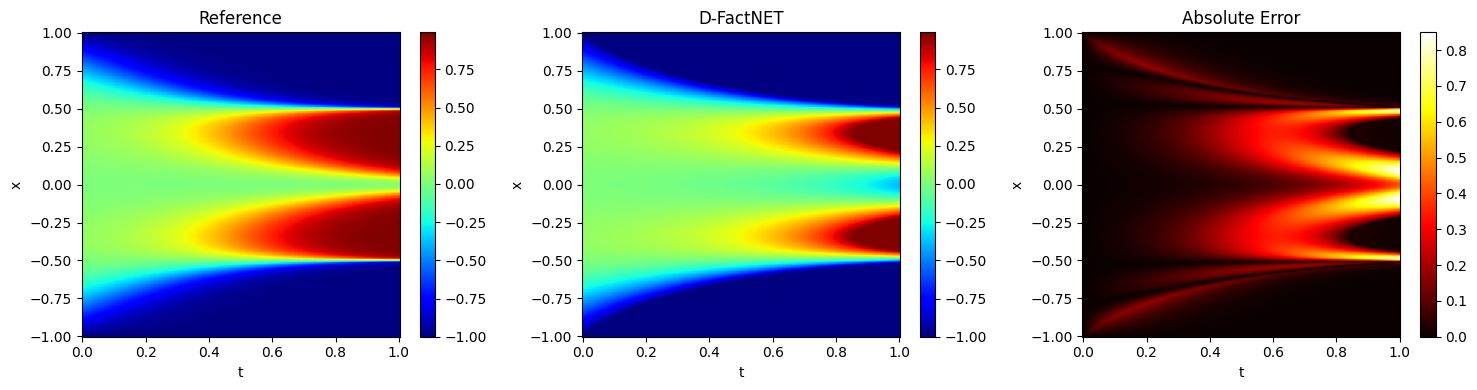

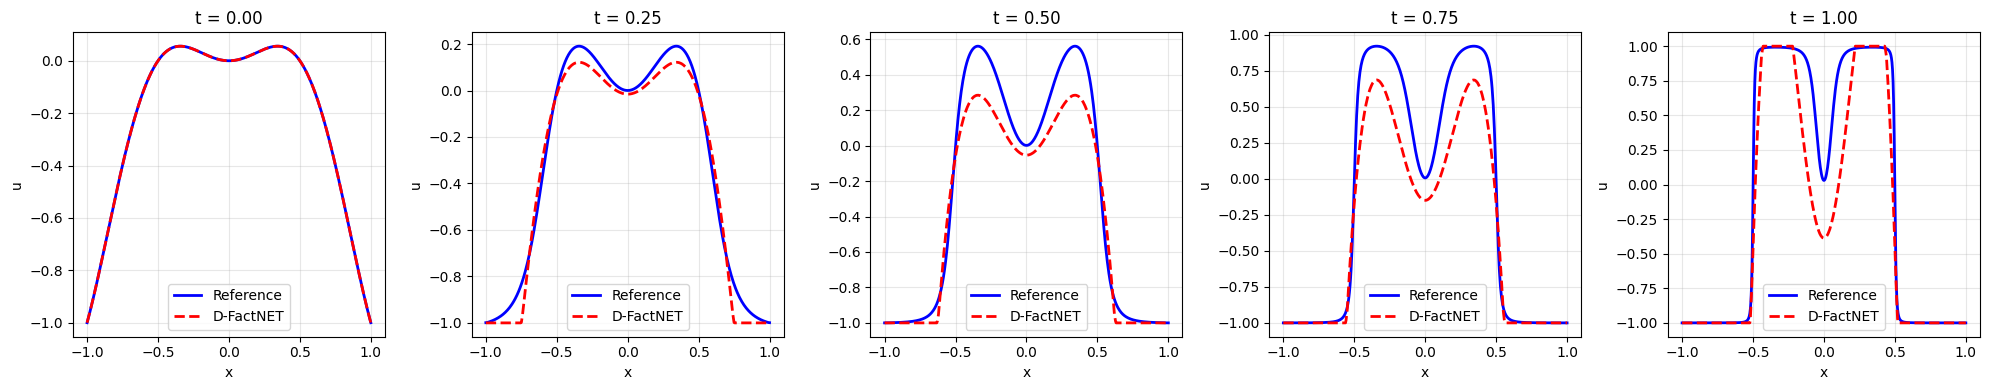

In [8]:



def solve_dfactnet(learned_coeff, u0, x_star, approx_dx=0.01, approx_dt=1e-4):
    """Solve using D-FactNET learned coefficients."""
    approx_x = jnp.arange(-1.0, 1.0, approx_dx)
    approx_t = jnp.arange(0, 1, approx_dt)
    approx_U0 = jnp.interp(approx_x, x_star, u0)

    A, B, C, D, E = [learned_coeff[:, i] for i in range(5)]
    update_coeff = jnp.stack([-A / D, -B / D, -C / D, -E / D], axis=1)

    def time_step(u_j, _, coeffs):
        u_im1, u_ij, u_ip1 = jnp.roll(u_j, 1), u_j, jnp.roll(u_j, -1)
        u_matrix = jnp.stack([u_im1, u_ij, u_ip1, jnp.ones_like(u_j)], axis=0)
        return jnp.median(jnp.clip(coeffs @ u_matrix, -1.0, 1.0), axis=0), None

    def full_solve(u0_vec, coeffs, num_steps):
        def step(carry, _):
            u = carry
            u_new, _ = time_step(u, None, coeffs)
            return u_new, u
        _, U = jax.lax.scan(step, u0_vec, None, length=num_steps - 1)
        return jnp.vstack([u0_vec, U])

    U_approx = full_solve(approx_U0, update_coeff, len(approx_t))
    return approx_t, approx_x, U_approx


def interpolate_to_ref_grid(u_approx, t_approx, x_approx, t_ref, x_ref):
    """Interpolate D-FactNET solution to reference grid for comparison."""
    from scipy.interpolate import RegularGridInterpolator

    # Create interpolator (scipy needs numpy arrays)
    interp = RegularGridInterpolator(
        (np.array(t_approx), np.array(x_approx)),
        np.array(u_approx),
        method='linear',
        bounds_error=False,
        fill_value=None
    )

    # Create meshgrid of reference points
    TT, XX = np.meshgrid(t_ref, x_ref, indexing='ij')
    points = np.stack([TT.flatten(), XX.flatten()], axis=-1)

    # Interpolate
    u_interp = interp(points).reshape(len(t_ref), len(x_ref))
    return jnp.array(u_interp)


def compute_errors(u_approx, u_ref):
    """Compute various error metrics."""
    # L2 relative error
    l2_rel = float(jnp.linalg.norm(u_approx - u_ref) / jnp.linalg.norm(u_ref))

    # L_inf error
    l_inf = float(jnp.max(jnp.abs(u_approx - u_ref)))

    # MSE
    mse = float(jnp.mean((u_approx - u_ref) ** 2))

    # MAE
    mae = float(jnp.mean(jnp.abs(u_approx - u_ref)))

    return {
        'l2_relative': l2_rel,
        'l_inf': l_inf,
        'mse': mse,
        'mae': mae,
    }


def plot_comparison(u_ref, u_approx, t_star, x_star, save_prefix='dfactnet'):
    """Plot reference, approximation, and error."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    vmin, vmax = u_ref.min(), u_ref.max()

    # Reference
    im0 = axes[0].pcolormesh(t_star, x_star, u_ref.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
    axes[0].set_xlabel('t')
    axes[0].set_ylabel('x')
    axes[0].set_title('Reference')
    plt.colorbar(im0, ax=axes[0])

    # D-FactNET
    im1 = axes[1].pcolormesh(t_star, x_star, u_approx.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
    axes[1].set_xlabel('t')
    axes[1].set_ylabel('x')
    axes[1].set_title('D-FactNET')
    plt.colorbar(im1, ax=axes[1])

    # Error
    error = jnp.abs(u_ref - u_approx)
    im2 = axes[2].pcolormesh(t_star, x_star, error.T, cmap='hot', shading='auto')
    axes[2].set_xlabel('t')
    axes[2].set_ylabel('x')
    axes[2].set_title('Absolute Error')
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.savefig(f'{save_prefix}_comparison.png', dpi=150)
    plt.show()


def plot_slices(u_ref, u_approx, t_star, x_star, time_slices=[0.0, 0.25, 0.5, 0.75, 1.0], save_prefix='dfactnet'):
    """Plot solution slices at different times."""
    fig, axes = plt.subplots(1, len(time_slices), figsize=(4 * len(time_slices), 4))

    for ax, t_val in zip(axes, time_slices):
        t_idx = int(t_val * (len(t_star) - 1))
        ax.plot(x_star, u_ref[t_idx, :], 'b-', lw=2, label='Reference')
        ax.plot(x_star, u_approx[t_idx, :], 'r--', lw=2, label='D-FactNET')
        ax.set_xlabel('x')
        ax.set_ylabel('u')
        ax.set_title(f't = {t_star[t_idx]:.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_prefix}_slices.png', dpi=150)
    plt.show()


# ==========================================
# Main
# ==========================================

if __name__ == "__main__":
    print("JAX devices:", jax.devices())

    # Load reference data
    data_mat = scipy.io.loadmat('allen_cahn.mat')
    u_ref = data_mat['usol']
    t_star = data_mat['t'].flatten()
    x_star = data_mat['x'].flatten()
    u0 = u_ref[0, :]

    print(f"Reference grid: t={len(t_star)}, x={len(x_star)}")
    print(f"Reference shape: {u_ref.shape}")

    # Load D-FactNET
    mlp_arch = MLP(num_layers=4, hidden_dim=512, output_dim=15, activation=nn.tanh)
    factorizer = MLPFactorizer(mlp_arch, skip_init=True)
    learned_coeff = factorizer.load_model('/home/madheshmd/grad/Assigments/ac_1d_v1')
    print("D-FactNET loaded.")

    # Solve with D-FactNET
    approx_t, approx_x, U_approx = solve_dfactnet(learned_coeff, u0, x_star)
    print(f"D-FactNET grid: t={len(approx_t)}, x={len(approx_x)}")
    print(f"D-FactNET shape: {U_approx.shape}")

    # Interpolate to reference grid
    u_approx_interp = interpolate_to_ref_grid(U_approx, approx_t, approx_x, t_star, x_star)
    print(f"Interpolated shape: {u_approx_interp.shape}")

    # Compute errors
    errors = compute_errors(u_approx_interp, u_ref)
    print("\n" + "=" * 40)
    print("D-FactNET Error Analysis")
    print("=" * 40)
    print(f"L2 Relative Error: {errors['l2_relative']:.4e}")
    print(f"L_inf Error:       {errors['l_inf']:.4e}")
    print(f"MSE:               {errors['mse']:.4e}")
    print(f"MAE:               {errors['mae']:.4e}")
    print("=" * 40)

    # Plot
    plot_comparison(u_ref, u_approx_interp, t_star, x_star)
    plot_slices(u_ref, u_approx_interp, t_star, x_star)